In [73]:
import os
import shutil
import glob
import SimpleITK as sitk
import six
import radiomics
import getopt
import sys
from pydicom import dcmread
import dicom2nifti
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from radiomics import featureextractor, getTestCase
import pydicom
import pydicom_seg
import SimpleITK as sitk
import ast
import json
import pandas
import seaborn as sns
# importing the zipfile module
from zipfile import ZipFile
BASE_PATH = "../../../data4/hrehman/Clinical Data/"

BASE_PATH_zipped = "/data/radiogenomics/data/NSCLC_Radiogenomics/raw/"
# INPUT_FOLDER = 'data4/Clinical Data/3-13-2023/'
INPUT_FOLDER = BASE_PATH + '3-13-2023/'
INPUT_FOLDER_zipped = BASE_PATH_zipped
patients_zipped = os.listdir(INPUT_FOLDER_zipped)
patients_zipped.sort()
segmentaion_dict = {}

Comparison of brain test images from github with the data we have and see if everything is ok

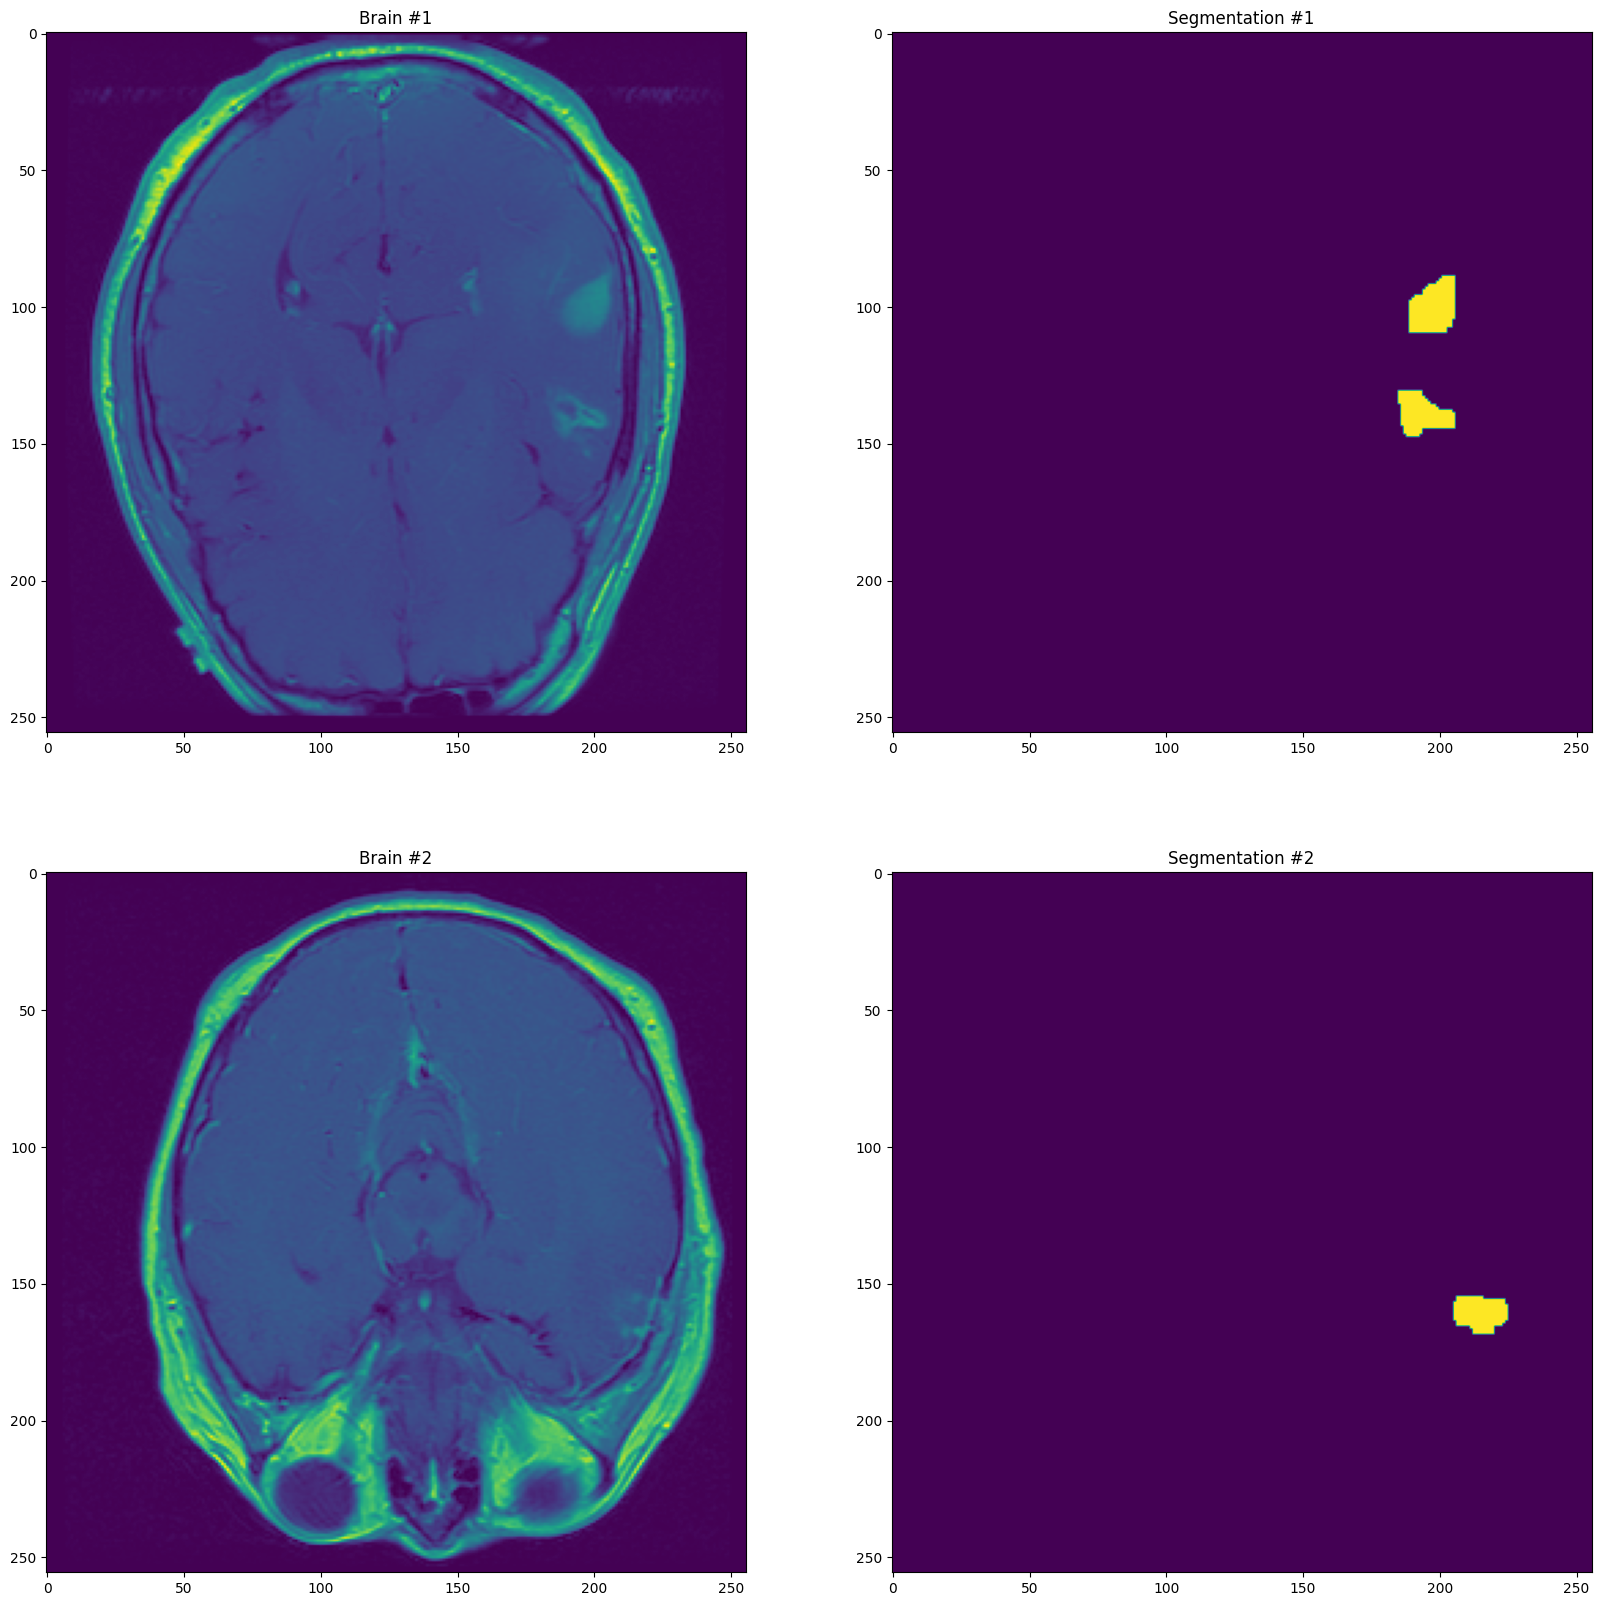

In [2]:
import os
import SimpleITK as sitk

from radiomics import getTestCase

imagepath_1, labelpath_1 = getTestCase('brain1')
imagepath_2, labelpath_2 = getTestCase('brain2')

image_1 = sitk.ReadImage(imagepath_1)
label_1 = sitk.ReadImage(labelpath_1)
image_2 = sitk.ReadImage(imagepath_2)
label_2 = sitk.ReadImage(labelpath_2)
# Display the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
# First image
plt.subplot(2,2,1)
plt.imshow(sitk.GetArrayFromImage(image_1)[12,:,:])
plt.title("Brain #1")
plt.subplot(2,2,2)
plt.imshow(sitk.GetArrayFromImage(label_1)[12,:,:])        
plt.title("Segmentation #1")

# Second image
plt.subplot(2,2,3)
plt.imshow(sitk.GetArrayFromImage(image_2)[8,:,:])        
plt.title("Brain #2")

plt.subplot(2,2,4)
plt.imshow(sitk.GetArrayFromImage(label_2)[8,:,:])        
plt.title("Segmentation #2")

plt.show()

Here we will unzip the data of all tghe patients to another folder and once the dicoms are extracted, we will convert to Nifti and delete the original one

In [75]:
def unzipping_segFiles():
    for patient in patients_zipped:
        zipped_folder = os.listdir(BASE_PATH_zipped + patient + "/SEG/")[0]
        with ZipFile(BASE_PATH_zipped + patient + "/SEG/" + zipped_folder, 'r') as zip:
            # printing all the contents of the zip file
            # extracting all the files
            print('Extracting all the files now...')
            zip.extractall(INPUT_FOLDER + patient + "/SEG/")
            print('Done!')
def unzipping_ctFiles():
    for patient in patients_zipped:
        zipped_folder = os.listdir(BASE_PATH_zipped + patient + "/CT/")[0]
        with ZipFile(BASE_PATH_zipped + patient + "/CT/" + zipped_folder, 'r') as zip:
            # printing all the contents of the zip file
            # extracting all the files
            print('Extracting all the files now...')
            zip.extractall(INPUT_FOLDER + patient + "/CT/")
            print('Done!')
#Uncommets these lines if you have to unzip the dicoms
# unzipping_segFiles()
# unzipping_ctFiles()

#Once all the files are unzipped into a new location , we will read all the patinets
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [4]:
len(patients)

138

In [69]:
# These are all those patients who have missing segmentations 
# patients = ["R01-020","R01-049","R01-052","R01-056","R01-075","R01-090","R01-098","R01-026","R01-044","R01-048","R01-078"]

In [71]:
def last_4chars(x):
    return(x[-1:])

def sort_dcm_files_CT(patient):
    folder = os.listdir(INPUT_FOLDER + patient + '/CT/')
    path = INPUT_FOLDER + patient + '/CT/'
    list_of_files = os.listdir(path)
    # for specific cases like the patinets in the above cell you can see they have different file formate, in order to fix this we have to perform sorting on the second part of the filename
    # this line is for sorting on first part of the -
    list_of_files = sorted(list_of_files, key=lambda x: int(x.split("-")[0]))
    # this line is for sorting on second part of the - for the patinets that are above mentioned
    # list_of_files = sorted(list_of_files, key=lambda x: int(str(x.split("-")[1]).split(".")[0]))
    return list_of_files
def get_SEG(patient):
    folder = os.listdir(INPUT_FOLDER + patient + '/SEG')
    path = INPUT_FOLDER + patient + '/SEG/'
    file = os.listdir(path)
    return file

def get_reference_segmnetation(ds):
    reference_CT = ds[0x0008, 0x1115][0][0x0008, 0x114a]
    return reference_CT

In the follwing chuck we are reading each dicom file , find the corresponding segmentation of each dicom , and then create a json format file which saves the key as CT scan number and the value as the position of segmentation from all the stacked slices of a lung.
it took 7 minutes for the conversion

In [72]:
#iterating the patinets
for patient in patients:
    print(patient)
    segmentaion_dict = {}
    seg_ids = []
    #get a patient segmentation
    file = os.listdir(INPUT_FOLDER + patient + '/SEG')
    path = INPUT_FOLDER + patient + '/SEG/'
    # file = os.listdir(path)
    # print(patient)

    #Read the segmentation and get the reference CT of it
    SEG = dcmread(os.path.join(path,file[0]))
    segmentations = get_reference_segmnetation(SEG)
    #populate the dictionary with the values of segmentation as 0,1,2 ....
    for i,seg in enumerate(segmentations):
        seg_ids.append(str(seg[0x0008, 0x1155].value))
        segmentaion_dict[i] = ''

    #read files in sorted form according to the file system
    files = sort_dcm_files_CT(patient=patient)
    folder = os.listdir(INPUT_FOLDER + patient + '/CT')
    path = INPUT_FOLDER + patient + '/CT/'
    for file in files:
        CT = dcmread(os.path.join(path,file))
        # print(CT[0x0008, 0x0018].value)
        #read each file and find the slice number according to the SEG
        if str(CT[0x0008, 0x0018].value) in seg_ids:
            i = [i for i, j in enumerate(seg_ids) if j == str(CT[0x0008, 0x0018].value)]
            # for all the patinets #
            # segmentaion_dict[i[0]] = int(file.split('-')[0])-1
            # for some patinets as aboved mentioned
            # print("found")
            # print(str(file.split("-")[1]).split(".")[0])
            # print(i)
            segmentaion_dict[i[0]] = int(str(file.split("-")[1]).split(".")[0])-1
    #Write the information in a configuration file of each patient.
    with open( BASE_PATH + "Nifti/config/" + patient + ".txt", 'w') as f: 
        # for key, value in segmentaion_dict.items(): 
        #     f.write('%s:%s\n' % (key, value))
        json.dump(segmentaion_dict,f)

R01-014


convert dicom files to Nifti first for CT scans

In [78]:
# config_patinets = ["R01-020.txt","R01-049.txt","R01-052.txt","R01-056.txt","R01-075.txt","R01-090.txt","R01-098.txt"]
config_patinets = os.listdir(BASE_PATH + "Nifti/config")
len(config_patinets)

137

In [50]:
def convertCTFiles():
    count = 0
    for patient in patients:
        if str(patient+'.txt') in config_patinets:
            print(patient)
            path = BASE_PATH + "Nifti/" + patient + '/CT/'
            # folder = os.listdir(INPUT_FOLDER + patient + '/CT/')
            if os.path.exists(path=path) == False:
                os.makedirs(path)
            # dicom2nifti.convert_directory(INPUT_FOLDER + patient + '/CT' + folder[0],path,sorter=last_4chars)
            files = sort_dcm_files_CT(patient=patient)
            dicom_list = [pydicom.read_file(os.path.join(INPUT_FOLDER + patient + '/CT/', f)) for f in files]
            dicom2nifti.convert_dicom.dicom_array_to_nifti(dicom_list,os.path.join(path, 'output.nii'),reorient_nifti=False)
            # dicom2nifti.dicom_series_to_nifti(dicom_list,os.path.join(path, 'output.nii.gz'),reorient_nifti=False)

convert dicom files to Nifti of Segmentaion

In [51]:
def convertSEGFiles():
    for patient in patients:
        if str(patient+'.txt') in config_patinets:
            print(patient)
            path = BASE_PATH + "/Nifti/" + patient + '/SEG/'
            folder = os.listdir(INPUT_FOLDER + patient + '/SEG')
            if os.path.exists(path=path) == False:
                os.makedirs(path)
            file = os.listdir(INPUT_FOLDER + patient + '/SEG/')
            dcm = pydicom.dcmread(INPUT_FOLDER + patient + '/SEG/'+file[0])
            reader = pydicom_seg.SegmentReader()
            result = reader.read(dcm)
            # print(result.available_segments)
            for segment_number in result.available_segments:
                image_data = result.segment_data(segment_number)  # directly available
                image = result.segment_image(segment_number)  # lazy construction
                sitk.WriteImage(image, str(path) + str(segment_number) + ".nii")

In [54]:
#It took 11 minutes to run the whole thing
convertCTFiles()

R01-020
R01-049
R01-052
R01-056
R01-075
R01-090
R01-098
R01-026
R01-044
R01-048
R01-078


In [53]:
convertSEGFiles()

R01-020
R01-049
R01-052
R01-056
R01-075
R01-090
R01-098
R01-026
R01-044
R01-048
R01-078


In [17]:
#Delete all the unzipped dicom files since they are occupying the space for not reason
# os.remove(r"/data4/hrehman/Clinical Data/3-13-2023")
import shutil
shutil.rmtree("/data4/hrehman/Clinical Data/3-13-2023/")

Here im just checking if the dicom files also have same issues with the segmentation

In [55]:
# reading the data from the file
with open(BASE_PATH + 'Nifti/config/R01-001.txt',"r") as f:
   config =  json.load(f)
CT = sitk.ReadImage( BASE_PATH +"/Nifti/R01-001/CT/output.nii")
CT = sitk.GetArrayFromImage(CT)
SEG = sitk.ReadImage(BASE_PATH + "/Nifti/R01-001/SEG/1.nii")
SEG = sitk.GetArrayFromImage(SEG)
config.get("0") #this says that the first Segmentaion has original CT on 5
sampleCT = CT[config.get("12"),:,:]
sampleSeg = SEG[12,:,:]


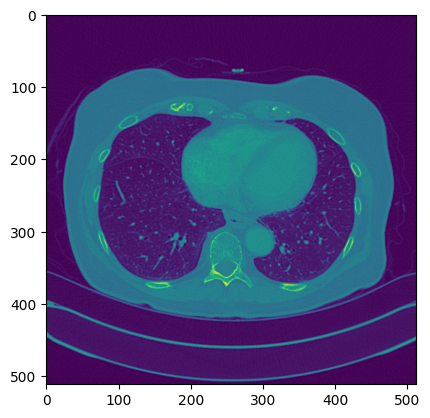

In [56]:
plt.imshow(sampleCT)

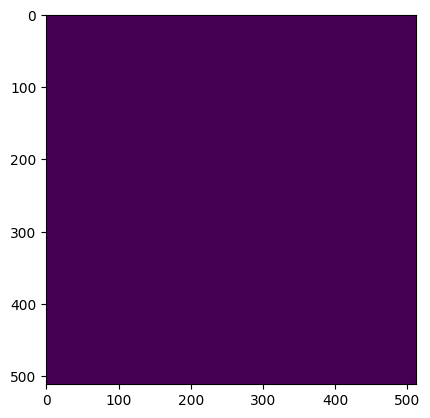

In [57]:
for i in range(0,50):
    plt.imshow(SEG[i,:,:])

We encountered a situation here where number of patines had nothing in the segmentation and had blank images , now the idea I have is to delete/ignore those slices which have all zeros and only give the ones with segmented portion

In [59]:

def findStart(SEG):
    start = True
    count = len(SEG)
    startval = 0
    i = 0
    #Running Array into the forward direction to find start of segmentation set
    for img in SEG:
        if(i == count):
            break
        else:
            countzero = np.count_nonzero(img)
            if countzero !=0 and start==True:
                start = False
                startval = i
                break
        i+=1
    return startval
def findEnd(SEG):
    end = True
    #Running Array into the backwards direction to find end of segmentation set
    i = len(SEG) -1
    count = 0
    endval = 0
    # SEG_rev = SEG[:, :, ::-1]
    SEG_rev  =np.flip(SEG, axis=None)
    # print(SEG_rev)
    for img in SEG_rev:
        if(i == count):
            break
        else:
            countzero = np.count_nonzero(img)
            if countzero !=0 and end==True:
                end = False
                endval = i
                break
        i-=1
    return endval

In [64]:
#detele the segmentation with all values as zero
# reading the data from the file

for patient in patients:
    if str(patient+'.txt') in config_patinets:
        # print(patient)
        with open(BASE_PATH + 'Nifti/config/'+patient+'.txt',"r") as f:
            config =  json.load(f)
            # print(len(config))
        path = BASE_PATH + "/Nifti/" + patient + '/SEG/'
        Segmentations = sitk.ReadImage(path + "1.nii")
        
        SEG = sitk.GetArrayFromImage(Segmentations)
        new_pixel_array = []
        
        #find start and end of the segmentation slices
        (start) = findStart(SEG)
        (end) = findEnd(SEG)
        ##Editing the configuration files
        i = 0
        count = len(SEG)
        for img in SEG:
            if start <= i and end >= i:
                new_pixel_array.append(img)
            else:
                config.pop(str(i))
            i+=1
        B = {str(j): v for j, v in enumerate(config.values())}
        # print(B)
        path = BASE_PATH + "/Nifti/" + patient + '/SEG/'
        if this is supposed to be a 3D gray scale image [x=3, y=20, z=10]
        img = sitk.GetImageFromArray(new_pixel_array)
        with open(BASE_PATH + 'Nifti/config/'+patient+'.txt','w') as f:
            json.dump(B,f)
        sitk.WriteImage(img, str(path) + "clean.nii")


delete the slices without segmentation (usually takes 2 min)

In [81]:
import nibabel as nib
import numpy as np
count = 0 
for patient in patients:
    count+=1
    if str(patient+'.txt') in config_patinets:
        path = BASE_PATH + "Nifti/" + patient + '/CT/'
        # Load the original NIfTI file
        nii_file = nib.load(path + "output.nii")

        # Get the image data as a Numpy array
        image_data = nii_file.get_fdata()

        # reading the data from the file
        with open(BASE_PATH + 'Nifti/config/'+patient+'.txt',"r") as f:
            config =  json.load(f)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
        # Define the dictionary that specifies the slice order
        slice_order = config
        
        # Create a new Numpy array to hold the reordered slices
        new_image_data = np.zeros((512,512,len(config)),dtype="int16")

        # Loop through the dictionary and copy each slice to its new position
        for new_idx, old_idx in slice_order.items():
            print()
            new_idx = int(new_idx)
            old_idx = int(old_idx)
            new_image_data[:, :, new_idx] = image_data[:, :, old_idx]

        # Create a new NIfTI file with the reordered slices
        new_nii_file = nib.Nifti1Image(new_image_data, nii_file.affine, header=nii_file.header)

        # Save the new NIfTI file
        nib.save(new_nii_file, path + "output_clean.nii")
print(count , "Patients CT data was cleaned with relavent segmentations")

extraction of radiomics features from one sample for testing purpose

In [43]:
# image  = BASE_PATH + "Nifti/R01-136/CT/output.nii"
# mask = BASE_PATH + "Nifti/R01-136/SEG/1.nii"
# mask = sitk.ReadImage(mask)
# image = sitk.ReadImage(image)
# image = sitk.Cast(image,sitk.sitkInt16)
# mask = sitk.Cast(mask,sitk.sitkInt16)
# plt.figure(figsize=(20,20))
# # First image
# plt.subplot(2,2,1)
# plt.imshow(sitk.GetArrayFromImage(image)[9,:,:])
# plt.title("Lungs #1")
# plt.subplot(2,2,2)
# plt.imshow(sitk.GetArrayFromImage(mask)[9,:,:])        
# plt.title("Segmentation #1")
# # save physical info
# spacing = image.GetSpacing()
# direction = image.GetDirection()
# origin = image.GetOrigin()
# # set physical info
# mask.SetSpacing(spacing)
# # image.SetSpacing([1.0]*3)
# mask.SetOrigin(origin)
# # image.SetOrigin([0.0]*3)
# mask.SetDirection(direction)
# # image.SetDirection([1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0])
# # restore physical
# # x.SetSpacing(spacing)
# # x.SetDirection(direction)
# extractor = featureextractor.RadiomicsFeatureExtractor(params)
# result = extractor.execute(image,mask)
# print(result.values())
# print('Result type:', type(result))  # result is returned in a Python ordered dictionary)
# print('')
# print('Calculated features')
# for key, value in six.iteritems(result):
#     print('\t', key, ':', value)

# Feature Extraction:

At this point we dont have to work with the conversion of the data anymore , we already have the relavent CT and the segmentation with us. Reading patinets data and try to extract the features

In [82]:
config_patinets = os.listdir(BASE_PATH + "Nifti/config")
len(config_patinets)

137

In [83]:
#Once all the files are unzipped into a new location , we will read all the patinets
patients = os.listdir(INPUT_FOLDER)
patients.sort()
params = './params.yml'
extractor = featureextractor.RadiomicsFeatureExtractor(params)
features = {}

for patient in patients:
    if str(patient+'.txt') in config_patinets:
        path = BASE_PATH + "Nifti/" + patient
        print(patient)
        image = sitk.ReadImage(path + "/CT/output_clean.nii")
        mask = sitk.ReadImage(path + "/SEG/clean.nii")
        # image = sitk.Cast(image,sitk.sitkInt16)
        # mask = sitk.Cast(mask,sitk.sitkInt16)
        # Since the origin and the physical space issue is encountred, we will set them same for both of the images
        # get physical info for image
        spacing = image.GetSpacing()
        direction = image.GetDirection()
        origin = image.GetOrigin()
        # set physical info
        mask.SetSpacing(spacing)
        mask.SetOrigin(origin)
        mask.SetDirection(direction)
        features[patient] = extractor.execute( image, mask)

R01-001
R01-002
R01-003
R01-004
R01-005
R01-006
R01-007
R01-008
R01-010
R01-011
R01-012
R01-013
R01-015
R01-016
R01-017
R01-018
R01-019
R01-020
R01-021
R01-022
R01-023
R01-024
R01-025
R01-026
R01-027
R01-028
R01-029
R01-030
R01-031
R01-032
R01-033
R01-034
R01-035
R01-036
R01-037
R01-038
R01-039
R01-040
R01-041
R01-042
R01-043
R01-044
R01-045
R01-046
R01-047
R01-048
R01-049
R01-050
R01-051
R01-052
R01-053
R01-054
R01-055
R01-056
R01-057
R01-058
R01-060
R01-061
R01-062
R01-063
R01-064
R01-065
R01-066
R01-067
R01-068
R01-069
R01-070
R01-071
R01-072
R01-073
R01-074
R01-075
R01-076
R01-077
R01-078
R01-079
R01-080
R01-081
R01-082
R01-083
R01-084
R01-085
R01-086
R01-087
R01-088
R01-089
R01-090
R01-091
R01-092
R01-093
R01-094
R01-095
R01-096
R01-097
R01-098
R01-099
R01-100
R01-101
R01-102
R01-103
R01-104
R01-105
R01-106
R01-107
R01-108
R01-109
R01-110
R01-111
R01-112
R01-113
R01-115
R01-117
R01-118
R01-122
R01-123
R01-124
R01-125
R01-126
R01-127
R01-128
R01-129
R01-130
R01-131
R01-132
R01-133


In [90]:
import json
import numpy as np

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

dumped = json.dumps(features, cls=NumpyEncoder)

with open(BASE_PATH + "Nifti/features.json", 'w') as f:
    json.dump(dumped, f)

In [95]:
with open(BASE_PATH + "Nifti/features.json", 'r') as f:
    data_read = json.load(f)

In [96]:
# A list of the valid features from any case id, sorted
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features.get('R01-003'))))

In [97]:
len(patients)

138

In [137]:
# Make a numpy array of all the values
import numpy as np
count = 0
samples = np.zeros((len(config_patinets),len(feature_names)))
for patient in patients:
    if str(patient+'.txt') in config_patinets:
        a = np.array([])
        for feature_name in feature_names:
            a = np.append(a, features[patient][feature_name])
        samples[count,:] = a
        count +=1
# May have NaNs
samples = np.nan_to_num(samples)

Now that we have all the features from all the patients from available dataset of 5 ids, we will use the above feature names and perform scaling

# Multidimensional scaling:

Multidimensional scaling or MDS is as way to visualize very high dimensional data in a lower dimensional space. In our case, the feature space is len(feature_names) (or 93) dimensional space. To help us understand the data, we project into 2d space. MDS preserves the relative distance between sample points during the projection, so two samples close together in 2d space would also be close together in the original 93-dimensional space (and vice versa).

We us non-metric algorithm, because our data are highly non uniform in the scale of each feature.

In [139]:
#With no metrics
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(samples)


seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=len(config_patinets),
                   dissimilarity="precomputed", n_jobs=1, metric=False)
pos_MDS = mds.fit_transform(similarities)

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [140]:
#With metrics
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(samples)


seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=len(config_patinets),
                   dissimilarity="precomputed", n_jobs=1, metric=True)
pos_PCA = mds.fit_transform(similarities)

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


# Plot

Here we use the results. NB: there are two points in the "green-ish" colored circle in the center of the plot.

Looking over our features, it's likely that meningioma and astrocytoma could be distinguisted by a classifier (based on our rather limited data set), but, in at least one case, glioma and astrocytoma features are relatively close together.

In [146]:
clinicalData = pandas.read_csv("/data4/hrehman/Clinical Data/NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv")
clinicalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 40 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Case ID                                            211 non-null    object 
 1   Patient affiliation                                211 non-null    object 
 2   Age at Histological Diagnosis                      211 non-null    int64  
 3   Weight (lbs)                                       211 non-null    object 
 4   Gender                                             211 non-null    object 
 5   Ethnicity                                          211 non-null    object 
 6   Smoking status                                     211 non-null    object 
 7   Pack Years                                         163 non-null    object 
 8   Quit Smoking Year                                  108 non-null    float64
 9   %GG       

In [147]:
histrology  = clinicalData[['Histology ','Case ID']]
histrology.rename(columns = {'Histology ':'Histology'}, inplace = True)
histrology  = histrology[histrology['Case ID'].str.contains("R01-")]
ids = [s.strip(".txt") for s in config_patinets]
histrology = histrology[histrology['Case ID'].isin(ids)]
histrology['uid'] = np.arange(len(config_patinets))
histrology.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 49 to 194
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Histology  137 non-null    object
 1   Case ID    137 non-null    object
 2   uid        137 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.3+ KB


/tmp/ipykernel_914188/2304738963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  histrology.rename(columns = {'Histology ':'Histology'}, inplace = True)


In [148]:
histrology.head()

,Histology,Case ID,uid
49,Adenocarcinoma,R01-001,0
50,Adenocarcinoma,R01-002,1
51,Adenocarcinoma,R01-003,2
52,Squamous cell carcinoma,R01-004,3
53,Adenocarcinoma,R01-005,4


In [149]:
from sklearn.preprocessing import LabelEncoder
survival_status = clinicalData[['Survival Status','Case ID']]
survival_status  = survival_status[survival_status['Case ID'].str.contains("R01-")]
ids = [s.strip(".txt") for s in config_patinets]
survival_status = survival_status[survival_status['Case ID'].isin(ids)]
survival_status['uid'] = np.arange(len(config_patinets))
# creating instance of labelencoder
labelencoder = LabelEncoder()
survival_status['labels']  = labelencoder.fit_transform(survival_status['Survival Status'])
survival_status.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 49 to 194
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Survival Status  137 non-null    object
 1   Case ID          137 non-null    object
 2   uid              137 non-null    int64 
 3   labels           137 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 5.4+ KB


In [150]:
survival_status.head()

,Survival Status,Case ID,uid,labels
49,Alive,R01-001,0,0
50,Alive,R01-002,1,0
51,Alive,R01-003,2,0
52,Alive,R01-004,3,0
53,Dead,R01-005,4,1


# With Type of Tumor

with MDS

/tmp/ipykernel_914188/3555333915.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


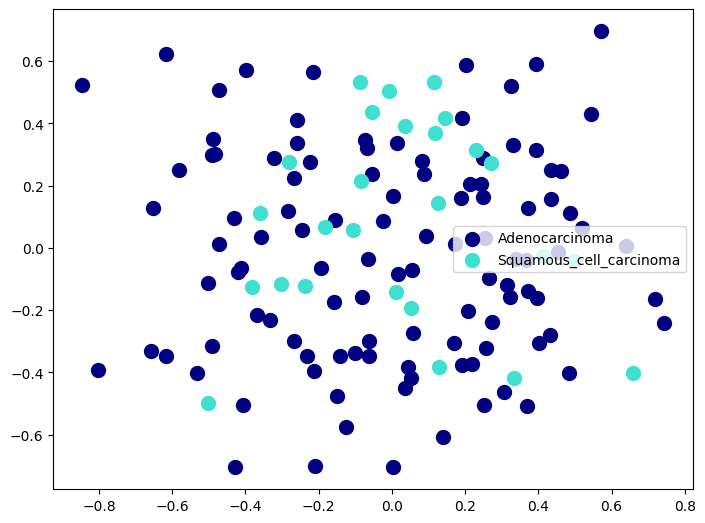

In [151]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import pandas as pd

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# Type of tumor
Adenocarcinoma = histrology[histrology['Histology']=="Adenocarcinoma"]['uid'].values
Squamous_cell_carcinoma= histrology[histrology['Histology']=="Squamous cell carcinoma"]['uid'].values

plt.scatter(pos_MDS[Adenocarcinoma, 0], pos_MDS[Adenocarcinoma, 1], color='navy', alpha=1.0, s=s, lw=1, label='Adenocarcinoma')
plt.scatter(pos_MDS[Squamous_cell_carcinoma, 0], pos_MDS[Squamous_cell_carcinoma, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Squamous_cell_carcinoma')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

/tmp/ipykernel_914188/460703106.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


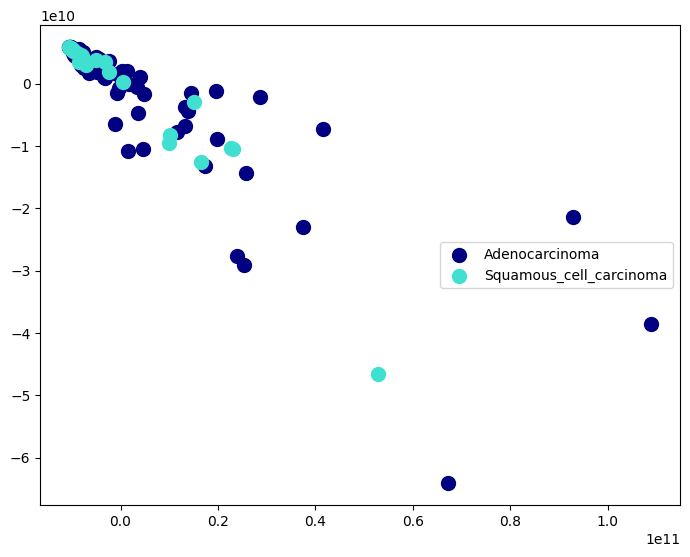

In [152]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# Type of tumor
Adenocarcinoma = histrology[histrology['Histology']=="Adenocarcinoma"]['uid'].values
Squamous_cell_carcinoma= histrology[histrology['Histology']=="Squamous cell carcinoma"]['uid'].values

plt.scatter(pos_PCA[Adenocarcinoma, 0], pos_PCA[Adenocarcinoma, 1], color='navy', alpha=1.0, s=s, lw=1, label='Adenocarcinoma')
plt.scatter(pos_PCA[Squamous_cell_carcinoma, 0], pos_PCA[Squamous_cell_carcinoma, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Squamous_cell_carcinoma')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

# With Type of Survial Status

/tmp/ipykernel_914188/822239636.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


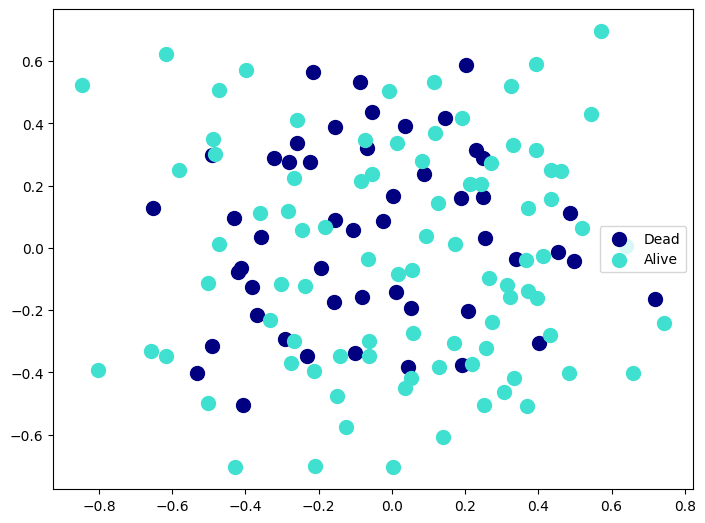

In [153]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# survival status
dead = survival_status[survival_status['labels']==1]['uid'].values
alive = survival_status[survival_status['labels']==0]['uid'].values

plt.scatter(pos_MDS[dead, 0], pos_MDS[dead, 1], color='navy', alpha=1.0, s=s, lw=1, label='Dead')
plt.scatter(pos_MDS[alive, 0], pos_MDS[alive, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Alive')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

/tmp/ipykernel_914188/983176487.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


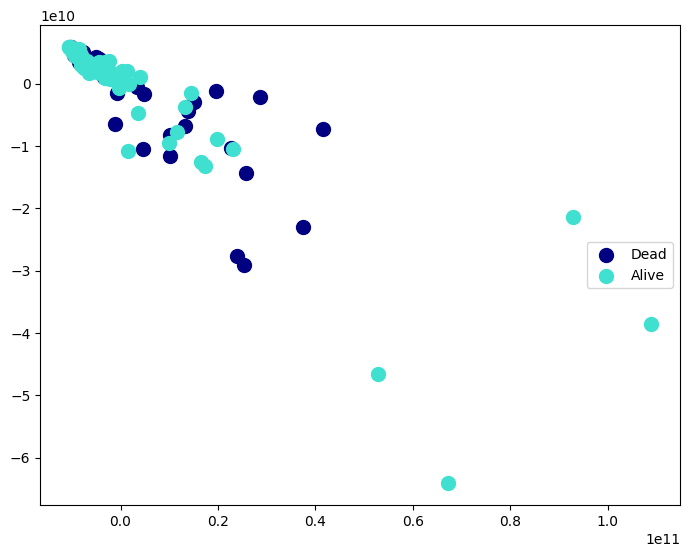

In [154]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# survival status
dead = survival_status[survival_status['labels']==1]['uid'].values
alive = survival_status[survival_status['labels']==0]['uid'].values

plt.scatter(pos_PCA[dead, 0], pos_PCA[dead, 1], color='navy', alpha=1.0, s=s, lw=1, label='Dead')
plt.scatter(pos_PCA[alive, 0], pos_PCA[alive, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Alive')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

# Plot features as a heatmap

In [119]:
# data_labels = pd.read_csv("/data4/hrehman/Clinical Data/NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv")
# data_labels = data_labels['']
# types = np.array(csv['Histology'])

In [120]:
# import pandas as pd
# import seaborn as sns

# # type of each tumor
# types =['meningioma', 'meningioma', 'meningioma', 'glioma', 'astrocytoma', 'glioma', 'astrocytoma', 'astrocytoma', 'astrocytoma', 'glioma']
# types = 

# # Construct a pandas dataframe from the samples
# d = pd.DataFrame(data=samples, columns=feature_names, index=types)

# corr = d.corr()

# # Set up the matplotlib figure, make it big!
# f, ax = plt.subplots(figsize=(15, 10))

# # Draw the heatmap using seaborn
# sns.heatmap(corr, vmax=.8, square=True)

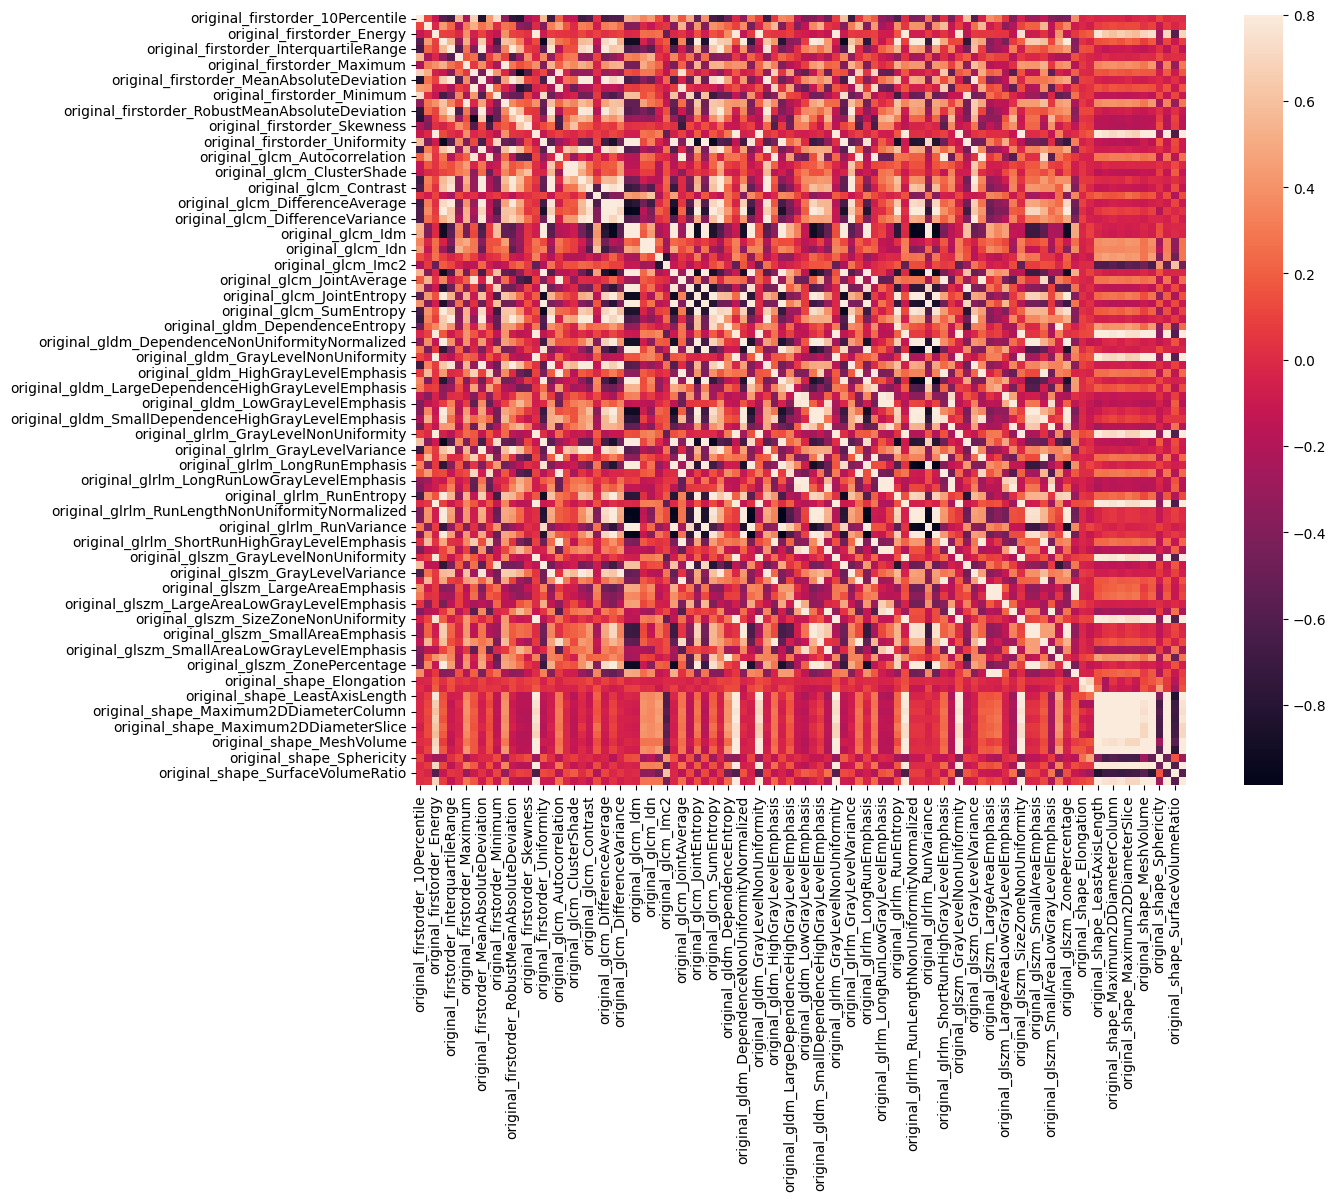

In [155]:


# Construct a pandas dataframe from the samples
d = pandas.DataFrame(data=samples, columns=feature_names)
corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)
plt.show()

# Cluster the heatmap

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/hrehman/radiomics_venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


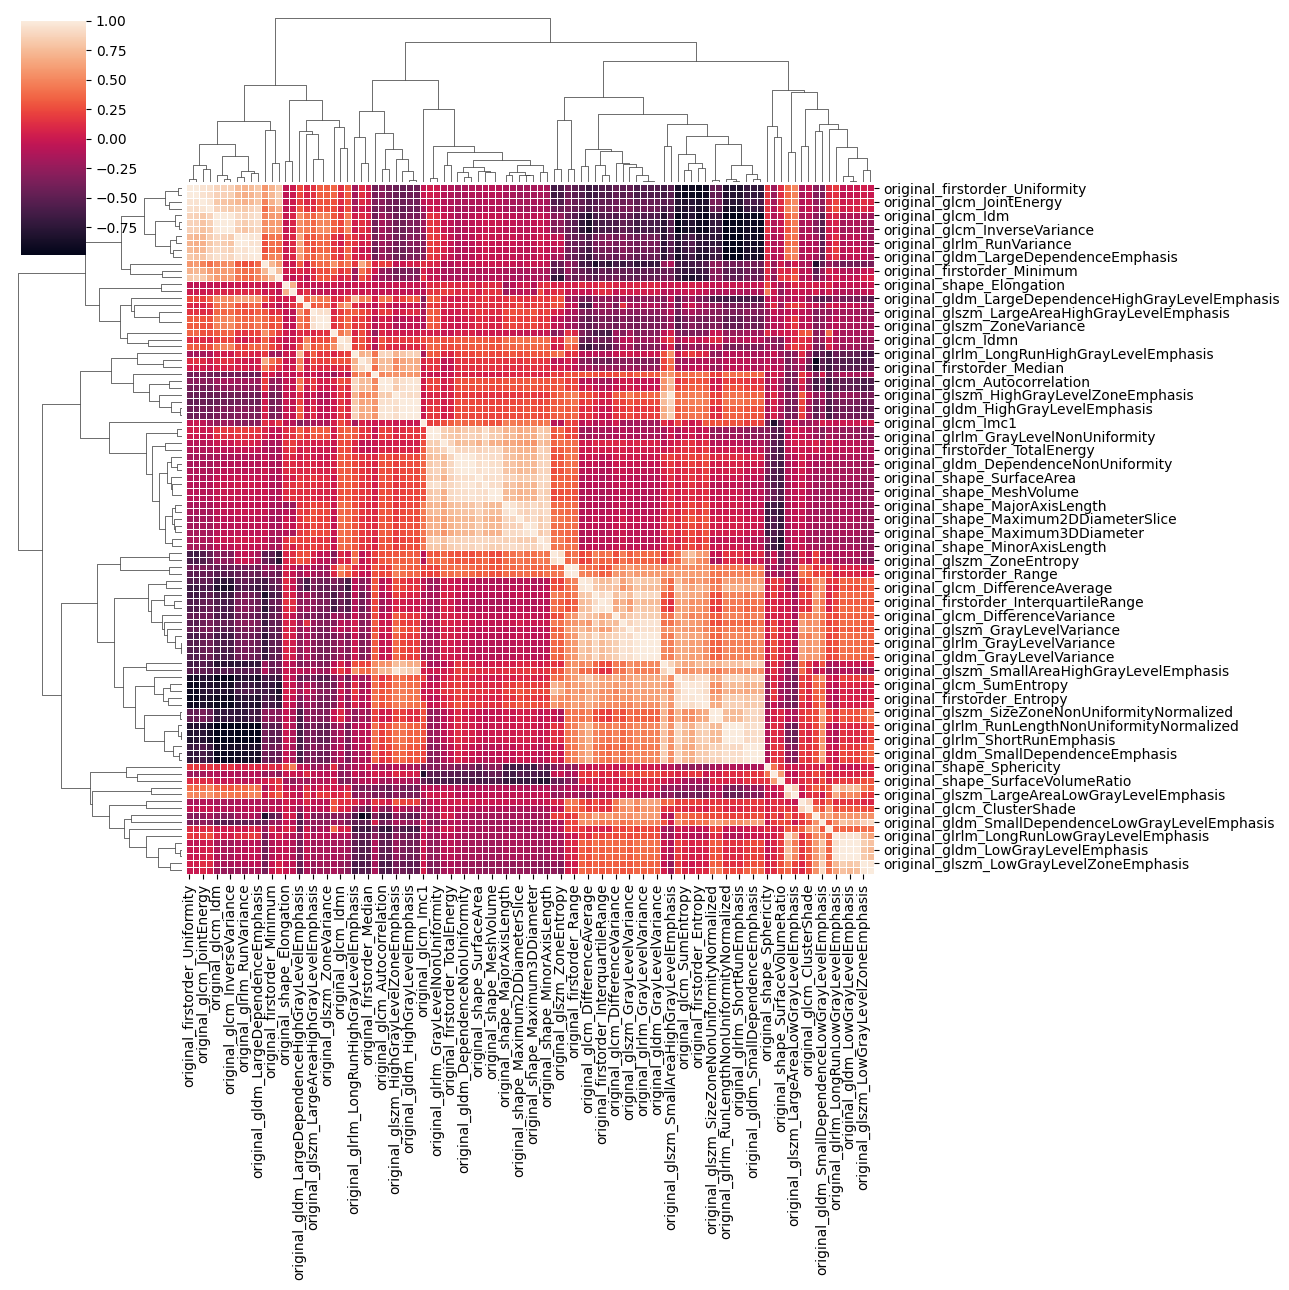

In [156]:
# Choose a subset of features for clustering
dd = d.iloc[:,:]

pp = sns.clustermap(dd.corr(), linewidths=.5, figsize=(13,13))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

# PCP

In [159]:
d['uid'] = np.arange(len(config_patinets))
d['survival_status'] = list(survival_status['labels'])
d

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,uid,survival_status
0,-857.2,133.0,5.215590e+08,4.531877,555.0,2.824333,1240.0,-142.708349,344.090404,60.0,...,17.826214,22.938612,1284.175988,12.898148,0.631682,904.486369,0.704332,1307.151699,0,0
1,-905.0,2.1,1.214916e+09,4.188372,214.0,3.098973,595.0,-664.940930,286.011588,-845.5,...,20.974246,24.758850,2138.929492,13.820376,0.699161,1148.253698,0.536836,2169.325270,1,0
2,-892.0,109.7,5.028621e+08,5.011884,877.5,2.306137,1363.0,-369.301360,457.164063,-284.0,...,20.194368,21.745150,1434.448242,12.054072,0.759558,809.803327,0.564540,1454.589844,2,0
3,-907.4,92.0,3.524431e+08,4.817136,820.0,1.932901,267.0,-260.190045,352.242571,-58.0,...,18.609795,24.935199,1302.181409,13.547928,0.576187,1000.847660,0.768593,1326.148376,3,0
4,-966.0,90.0,5.951477e+09,4.927582,946.0,2.596059,1585.0,-325.666346,451.888054,-100.0,...,32.504794,33.887109,7096.936377,21.398453,0.681077,2622.215627,0.369486,7117.235661,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,-924.0,122.3,5.850965e+09,5.181854,810.0,2.048549,1267.0,-536.563603,381.150943,-767.0,...,37.371606,46.325951,7664.534569,22.143302,0.573403,3278.546314,0.427755,7704.986572,132,0
133,-788.0,210.0,4.051197e+09,5.427343,684.0,2.539270,1854.0,-166.871699,330.676381,-18.0,...,54.074506,62.712243,23696.295016,31.088503,0.592916,6728.904765,0.283964,23776.760269,133,0
134,-866.0,145.0,2.235567e+09,5.394896,828.0,10.381470,3071.0,-276.307998,406.308058,-109.0,...,38.570317,40.669324,5143.475750,26.537007,0.516694,2788.830087,0.542207,5184.012286,134,0
135,-920.0,126.0,2.413557e+10,5.185304,889.0,1.911166,1645.0,-420.256350,446.847887,-655.0,...,48.083128,54.922185,24489.861041,34.054021,0.492826,8275.252693,0.337905,24553.646679,135,0


In [168]:
d.columns

Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation',
       'original_firstorder_Median',
       ...
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'uid', 'survival_status'],
      dtype='object', length=102)

In [170]:
import plotly.express as px
df = d
fig = px.parallel_coordinates(df,
                              dimensions=['uid','survival_status','original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume',
                                          'original_shape_SurfaceVolumeRatio'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()

Show the distribution of different variables

In [ ]:
# make a cleaner vefirst_colson
clean_df = df[feature_names].copy()
# clean_df.columns = [
#     ' '.join(c_col.split('original_')[-1].split('_')) 
#     for c_col in feature_names
# ]
clean_col_names = clean_df.columns[len(feature_names):]
# fix some of the artifacts from the radiomics tool
obj_cols = clean_df[clean_col_names].select_dtypes(['object']).columns.tolist()
for c_col in obj_cols:
    clean_df[c_col] = clean_df[c_col].map(lambda x: float(x))
clean_df.to_csv('clean_radiomics_table.csv', index=False)
clean_df.sample(3)

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
42,-307.9,198.9,3.635939e+08,5.075372,264.0,4.537922,1123.0,-51.949185,161.474017,-55.0,...,26.835454,26.118649,31.223817,31.821052,4825.890541,20.397169,0.614306,2248.111534,0.465844,4852.386475
62,-63.0,118.0,1.640657e+07,3.564481,90.0,3.449888,341.0,30.878628,56.601157,35.0,...,25.997671,25.997671,27.332587,32.205699,2879.791260,19.145409,0.528215,1853.165119,0.643507,2914.672852
86,-889.0,87.0,6.603114e+09,5.010352,860.0,1.708341,1330.0,-344.533614,409.110531,-116.0,...,41.828919,45.322266,47.260004,47.260004,10324.990894,29.091865,0.459492,4990.365267,0.483329,10399.376335


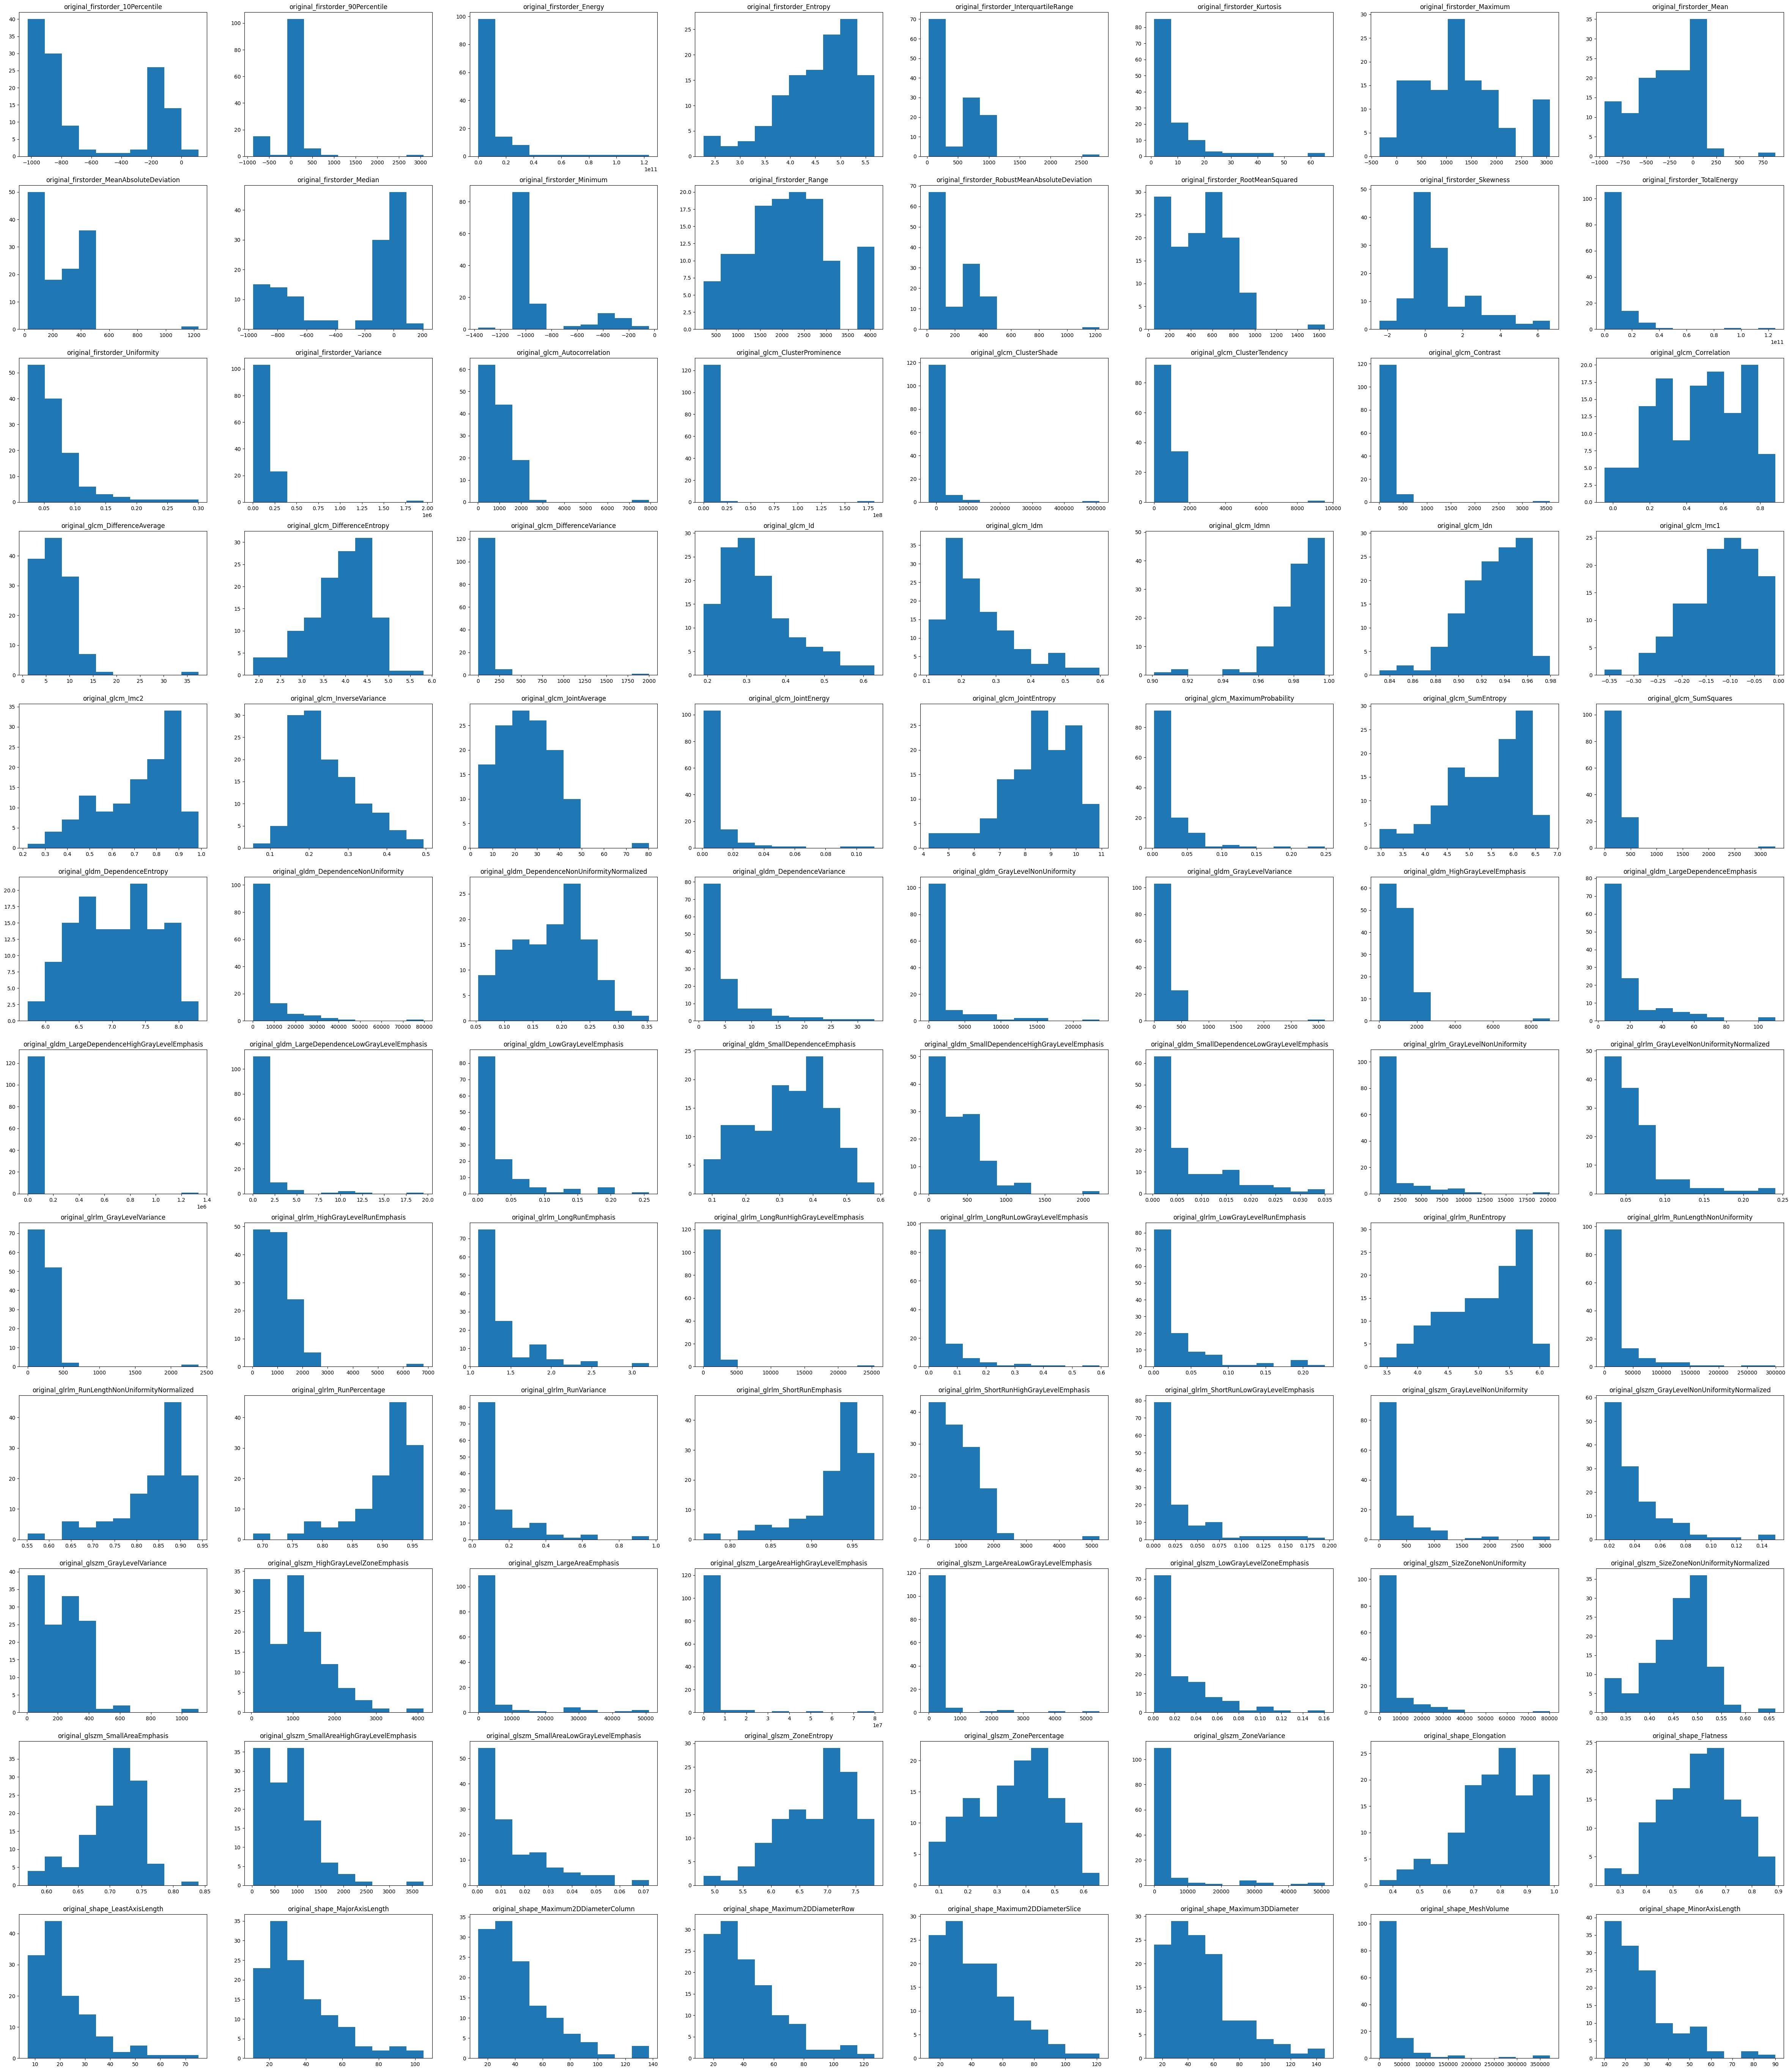

In [ ]:
fig, m_axs = plt.subplots(12, 8, figsize=(60, 70))
for c_ax, c_var in zip(m_axs.flatten(), feature_names):
    c_ax.hist(clean_df[c_var].values, bins=10)
    c_ax.set_title('\n'.join(c_var.split(' ')))
fig.savefig('all_metrics.png')